# Lokalizacja punktu w przestrzeni dwuwymiarowej – metoda trapezowa 

## Wprowadzenie do problemu lokalizacji punktu na płaszczyźnie
### Dane:
Poligonowy podział płaszczyzny (tzw. podział planarny) $S$. Należy go przetworzyć (zapisując wyniki w odpowiedniej strukturze
danych) tak, aby umożliwić efektywne osiągnięcie celu.
### Cel:
Odszukanie wielokąta (ściany) zawierającego zadany punkt.

Możliwa jest sytuacja, że zadany punkt nie leży wewnątrz żadnej ze ścian. Aby uwzględnić taki przypadek, umieszczamy nasz podział w odpowiednio dużym prostokącie $R$. Wtedy w razie takiej sytuacji wskażemy obszar wyznaczony przez ten prostokąt.

## Metoda trapezowa
W przypadku podejścia do rozwiązania przedstawionego powyżej problemu metodą trapezową, podział płaszczyzny będzie reprezentowany przez zbiór odcinków $S$={$s$<sub>1</sub>,$s$<sub>2</sub>,...,$s$<sub>n</sub>}. Poczynione założenia:
- odcinki nie przecinają się, poza ewentualnie wierzchołkami
- żaden odcinek nie jest pionowy
- wierzchołki żadnych dwóch odcinków nie mają takiej samej współrzędnej x (poza końcami połączonych odcinków)

Drugie i trzecie założenie wskazują na to, że zbiór odcinków $S$ jest w położeniu ogólnym.

### Mapa trapezowa
Mapa trapezowa $T$($S$) jest podziałem $S$ na wielokąty wypukłe (trapezy lub trójkąty; będziemy je nazywać *trapezami*, traktując trójkąt jako zdegenerowany trapez, w którym jeden z boków zredukował się do zera) otrzymanym przez poprowadzenie dwóch rozszerzeń (odcinków) pionowych z każdego końca odcinka w $S$. Rozszerzenia kończą się, gdy napotkają inny odcinek $S$ lub
brzeg prostokąta (ramki) $R$. 

#### Struktury używane w ramach algorytmu przedstawione są w pliku DataStructures.

In [1]:
# importy
from time import time
from util import *
from DataStructures import *
from plotter import Presenter, Plotter
import tkinter as tk
from plotter_functions import trapezoidal_map_vis, findPointVisualised
from Examples import *


## Algorytmy potrzebne do rozwiązania problemu
### Randomizowany algorytm przyrostowy
Ideą tego algorytmu jest to, że przetwarzamy odcinki ze zbioru $S$ w losowej kolejności (bierzemy dowolną permutację). Dla pewnych przypadków otrzymana struktura przeszukiwań $D$ ma rozmiar kwadratowy i liniowy czas przeszukiwania, ale dla innych permutacji złożoności tych operacji będą dużo lepsze. Analiza złożoności tego algorytmu jest probabilistyczna. Jak się okazuje, oczekiwana złożoność czasowa konstrukcji mapy trapezowej to ```O(nlogn)```, oczekiwany rozmiar struktury przeszukiwań to ```O(n)```, natomiast oczekiwany czas zapytania dla dowolnego punktu to ```O(logn)```, gdzie *n* oznacza liczbę odcinków ze zbioru $S$, dla którego tę strukturę przygotowujemy.

#### Kod do pomocniczych funkcji znajduje się w pliku util. 
## Główna funkcja

In [2]:
def createTrapezoidalMap(segments):
    S = []    
    for i in permute(segments):    
        p1 = Point(i[0][0], i[0][1])
        p2 = Point(i[1][0], i[1][1])
        S.append(Segment(p1, p2))
    
    R = createOuter(segments)
    rootNode = DNode('tnode', R)
    T = DTree(rootNode)
    R.node = rootNode
    
    for segment in S:  
        intersectedTrapezoids = followSegment(T, segment)
        if len(intersectedTrapezoids) == 1:
            insertIntoOne(T, intersectedTrapezoids[0], segment)
        else:
            insertIntoMany(T, intersectedTrapezoids, segment)   
    return T

## Dodawanie do jednego trapezu

In [3]:
def insertIntoOne(T: DTree  , trapezoid : Trapezoid, segment : Segment):
    p, q = segment.left, segment.right
    bottomLeft = trapezoid.bottomLeft
    bottomRight = trapezoid.bottomRight
    topLeft = trapezoid.topLeft
    topRight = trapezoid.topRight
    
    left, right = None, None
    top = Trapezoid(trapezoid.topSegment, segment, p, q)
    bottom = Trapezoid(segment, trapezoid.bottomSegment, p, q)
    
    if trapezoid.leftPoint < p:
        left = Trapezoid(trapezoid.topSegment, trapezoid.bottomSegment, trapezoid.leftPoint, p)
        left.bottomLeft = bottomLeft
        left.topLeft = topLeft
        left.topRight = top
        left.bottomRight = bottom
        top.topLeft = left
        bottom.bottomLeft = left
        updateLeft(trapezoid, left)
    else:
        Segment.updateX(p.x)
        bottom.bottomLeft = bottomLeft
        top.topLeft = topLeft
        if bottomLeft:
            bottomLeft.bottomRight = bottom
            if bottomLeft.topSegment > segment:
                bottomLeft.topRight = top
                top.bottomLeft = bottomLeft
        if topLeft:
            topLeft.topRight = top
            if segment > topLeft.bottomSegment:
                topLeft.bottomRight = bottom
                bottom.topLeft = topLeft
                
    if trapezoid.rightPoint > q:
        right = Trapezoid(trapezoid.topSegment, trapezoid.bottomSegment, segment.right, trapezoid.rightPoint)
        right.bottomRight = bottomRight
        right.topRight = topRight
        right.bottomLeft = bottom
        right.topLeft = top
        top.topRight = right
        bottom.bottomRight = right
        updateRight(trapezoid, right)
    else:
        Segment.updateX(q.x)
        bottom.bottomRight = bottomRight
        top.topRight = topRight
        if bottomRight:
            bottomRight.bottomLeft = bottom
            if bottomRight.topSegment > segment:
                bottomRight.topLeft = top
                top.bottomRight = bottomRight
        if topRight:
            topRight.topLeft = top
            if segment > topRight.bottomSegment:
                topRight.bottomLeft = bottom
                bottom.topRight = topRight
                
    updateTreeOne(trapezoid, segment, left, top, bottom, right)
                

## Dodawanie do wielu trapezów

In [4]:
def insertIntoMany (T, trapezoids: list[Trapezoid], segment: Segment):
    p, q = segment.left, segment.right
    left, right = None, None
    newTrapezoidsAbove = []
    newTrapezoidsBelow = []
    n = len(trapezoids)
    first = trapezoids[0]
    bottomLeft = first.bottomLeft
    topLeft = first.topLeft
    topRight = first.topRight
    bottomRight = first.bottomRight
    Segment.updateX(first.rightPoint.x)
    
    if segment.isAbove(first.rightPoint):
        top = Trapezoid(first.topSegment, segment, p, first.rightPoint)
        bottom = Trapezoid(segment, first.bottomSegment, p, Point(Segment.x, segment.getY(Segment.x)))
        merge = "lower"
    else:
        top = Trapezoid(first.topSegment, segment, p, Point(Segment.x, segment.getY(Segment.x)))
        bottom = Trapezoid(segment, first.bottomSegment, p, first.rightPoint)
        merge = "upper"
        
    if first.leftPoint < p:
        left = Trapezoid(first.topSegment, first.bottomSegment, first.leftPoint, p)
        left.bottomLeft = bottomLeft
        left.topLeft = topLeft
        left.topRight = top
        left.bottomRight = bottom
        top.topLeft = left
        bottom.bottomLeft = left
        updateLeft(first, left)    
    else:           
        bottom.bottomLeft = bottomLeft
        top.topLeft = topLeft
        if bottomLeft:
            bottomLeft.bottomRight = bottom
            if bottomLeft.topSegment > segment:
                bottomLeft.topRight = top
                top.bottomLeft = bottomLeft
        if topLeft:
            topLeft.topRight = top
            if segment > topLeft.bottomSegment:
                topLeft.bottomRight = bottom
                bottom.topLeft = topLeft
                             
    if trapezoids[1] == first.bottomRight:
        top.topRight = topRight
        if topRight:
            topRight.topLeft = top
    else:
        bottom.bottomRight = bottomRight
        if bottomRight:
            bottomRight.bottomLeft = bottom
    
    newTrapezoidsAbove.append(top)
    newTrapezoidsBelow.append(bottom)
    
    for i in range(1, n-1):
        nextPoint = trapezoids[i].rightPoint
        bottomLeft = trapezoids[i].bottomLeft
        topLeft = trapezoids[i].topLeft
        topRight = trapezoids[i].topRight
        bottomRight = trapezoids[i].bottomRight
        Segment.updateX(nextPoint.x)
        
        if segment.isAbove(nextPoint):
            lowerRightPoint = Point(Segment.x, segment.getY(Segment.x))
            if merge == "upper":
                top.rightPoint = nextPoint
                t = Trapezoid(segment, trapezoids[i].bottomSegment, bottom.rightPoint, lowerRightPoint)
                bottom.topRight = t
                t.topLeft = bottom
                t.bottomLeft = bottomLeft
                if bottomLeft:
                    bottomLeft.bottomRight = t
                top.topRight = topRight
                if topRight:
                    topRight.topLeft = top
                bottom = t
                newTrapezoidsBelow.append(bottom)
            else:
                bottom.rightPoint = lowerRightPoint
                t = Trapezoid(trapezoids[i].topSegment, segment, top.rightPoint, nextPoint)
                top.bottomRight = t
                t.bottomLeft = top
                t.topLeft = topLeft
                t.topRight = topRight
                if topLeft:
                    topLeft.topRight = t
                if topRight:
                    topRight.topLeft = t
                top = t
                newTrapezoidsAbove.append(top)
            merge = "lower"   
        else:
            upperRightPoint = Point(Segment.x, segment.getY(Segment.x))
            if merge == "upper":
                top.rightPoint = upperRightPoint
                t = Trapezoid(segment, trapezoids[i].bottomSegment, bottom.rightPoint, nextPoint)
                bottom.topRight = t
                t.topLeft = bottom
                t.bottomLeft = bottomLeft
                t.bottomRight = bottomRight
                if bottomLeft:
                    bottomLeft.bottomRight = t
                if bottomRight:
                    bottomRight.bottomLeft = t
                bottom = t
                newTrapezoidsBelow.append(bottom)
            else:
                bottom.rightPoint = nextPoint
                t = Trapezoid(trapezoids[i].topSegment, segment, top.rightPoint, upperRightPoint)
                top.bottomRight = t
                t.bottomLeft = top
                t.topLeft = topLeft
                if topLeft:
                    topLeft.topRight = t
                bottom.bottomRight = bottomRight
                if bottomRight:
                    bottomRight.bottomLeft = bottom
                top = t
                newTrapezoidsAbove.append(top)
            merge="upper"
            
    last = trapezoids[n-1]
    bottomLeft = last.bottomLeft
    topLeft = last.topLeft
    topRight = last.topRight
    bottomRight = last.bottomRight
    Segment.updateX(last.rightPoint)
        
    if merge == "upper":
        top.rightPoint = q
        t = Trapezoid(segment, last.bottomSegment, bottom.rightPoint, q)
        bottom.topRight = t
        t.topLeft = bottom
        bottom = t
        newTrapezoidsBelow.append(bottom)
    else:
        bottom.rightPoint = q
        t = Trapezoid(last.topSegment, segment, top.rightPoint, q)
        top.bottomRight = t
        t.bottomLeft = top
        top = t
        newTrapezoidsAbove.append(top)
        
    if last.rightPoint > q:
        right = Trapezoid(last.topSegment, last.bottomSegment, q, last.rightPoint)
        right.bottomLeft = bottom
        right.topLeft = top
        right.topRight = topRight
        right.bottomRight = bottomRight
        top.topRight = right
        bottom.bottomRight = right
        updateRight(last, right)
    else:
        top.topRight = topRight
        bottom.bottomRight = bottomRight
        if bottomRight:
            bottomRight.bottomLeft = bottom
            if bottomRight.topSegment > segment:
                bottomRight.topLeft = top
                top.bottomRight = bottomRight
        if topRight:
            topRight.topLeft = top
            if segment > topRight.bottomSegment:
                topRight.bottomLeft = bottom
                bottom.topRight = topRight
                
    if last == trapezoids[n-2].topRight:
        bottom.bottomLeft = bottomLeft
        if bottomLeft:
            bottomLeft.bottomRight = bottom
    else:
        top.topLeft = topLeft
        if topLeft:
            topLeft.topRight = top
            
    updateTreeMany(trapezoids, segment, newTrapezoidsAbove, newTrapezoidsBelow, left, right)

## Analiza efektywności algorytmu
### Czas konstrukcji mapy trapezowej
Przetestujemy czas budowania mapy trapezowej dla zbiorów odcinków o różnej mocy. Aby były spełnione założenia, będziemy generować równoległe odcinki o końcach w różnych współrzędnych $x$. Tutaj nie będziemy wizualizować efektu, ponieważ ze względu na dużą liczbę trapezów w tej skali nie byłoby to czytelne (ale mapa jest konstruowana prawidłowo).

In [11]:
sizes = [100, 500, 1000, 5000, 10000, 50000, 75000, 100000]
x_size, y_size = 100, 100
trapezoidalMaps = []

# Służy do zapewnienia, że mapa będzie miała wystarczający rozmiar
base = [((0, 0),(x_size, 0)),((0, y_size),(x_size, y_size))] 

for n in sizes:
    segments = generateParallelSegments(x_size, y_size, n - 4)
    t1 = time()
    T = createTrapezoidalMap(segments + base)
    t2 = time()
    trapezoidalMaps.append(T)
    print("Czas budowania mapy trapezowej dla", n, "odcinków: {ex_time:.4f} s".format(ex_time = t2 - t1))

Czas budowania mapy trapezowej dla 100 odcinków: 0.0071 s
Czas budowania mapy trapezowej dla 500 odcinków: 0.0747 s
Czas budowania mapy trapezowej dla 1000 odcinków: 0.0426 s
Czas budowania mapy trapezowej dla 5000 odcinków: 0.3138 s
Czas budowania mapy trapezowej dla 10000 odcinków: 0.7110 s
Czas budowania mapy trapezowej dla 50000 odcinków: 4.1748 s
Czas budowania mapy trapezowej dla 75000 odcinków: 7.6602 s
Czas budowania mapy trapezowej dla 100000 odcinków: 7.9878 s


### Rozmiar struktury przeszukiwań 
Jako rozmiar struktury przeszukiwań rozumiemy liczbę węzłów (wszystkich, nie tylko liści).

In [12]:
for i in range(len(trapezoidalMaps)):
    T = trapezoidalMaps[i]
    DSize = [0]
    visited = set()
    calculateDSize(T.root, DSize, visited)
    print("Rozmiar struktury przeszukiwań dla", sizes[i], "odcinków:", DSize[0])

Rozmiar struktury przeszukiwań dla 100 odcinków: 935
Rozmiar struktury przeszukiwań dla 500 odcinków: 4915
Rozmiar struktury przeszukiwań dla 1000 odcinków: 8969
Rozmiar struktury przeszukiwań dla 5000 odcinków: 44367
Rozmiar struktury przeszukiwań dla 10000 odcinków: 87441
Rozmiar struktury przeszukiwań dla 50000 odcinków: 469321
Rozmiar struktury przeszukiwań dla 75000 odcinków: 701999
Rozmiar struktury przeszukiwań dla 100000 odcinków: 810689


### Czas wyszukiwania trapezu dla podanego punktu w mapie trapezowej
Testy poniżej mierzą czas znajdowania różnej liczby punktów w mapach trapezowych, zbudowanych na zadanej ilości odcinków
wygenerowanych losowo i spełniających wymagania zadania.

In [7]:
pointCount = 100000

for i in range(len(trapezoidalMaps)):
    print(f"Test dla mapy zbudowanej z {sizes[i]} odcinków")
    T = trapezoidalMaps[i]
    points = generateUniformPoints(x_size - 1, y_size - 1, pointCount)
    P = []
    for x,y in points:
        P.append(Point(x, y))
    
    t1 = time()
    for p in P:
        T.query(T.root, p)
    t2 = time()
    print("Czas wyszukiwania dla ", pointCount, "punktów: {ex_time:.4f} s".format(ex_time = t2 - t1))

Test dla mapy zbudowanej z 100 odcinków
Czas wyszukiwania dla  100000 punktów: 0.9347 s
Test dla mapy zbudowanej z 500 odcinków
Czas wyszukiwania dla  100000 punktów: 0.9743 s
Test dla mapy zbudowanej z 1000 odcinków
Czas wyszukiwania dla  100000 punktów: 1.1768 s
Test dla mapy zbudowanej z 5000 odcinków
Czas wyszukiwania dla  100000 punktów: 1.4468 s
Test dla mapy zbudowanej z 10000 odcinków
Czas wyszukiwania dla  100000 punktów: 1.5432 s
Test dla mapy zbudowanej z 50000 odcinków
Czas wyszukiwania dla  100000 punktów: 2.1882 s
Test dla mapy zbudowanej z 75000 odcinków
Czas wyszukiwania dla  100000 punktów: 2.1640 s
Test dla mapy zbudowanej z 100000 odcinków
Czas wyszukiwania dla  100000 punktów: 2.7462 s


## Tworzenie mapy trapezowej wraz z wizualizacją
Na początek przedstawimy parę wcześniej przygotowanych przykładów.

<IPython.core.display.Javascript object>


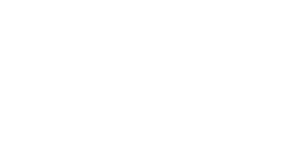

<IPython.core.display.Javascript object>


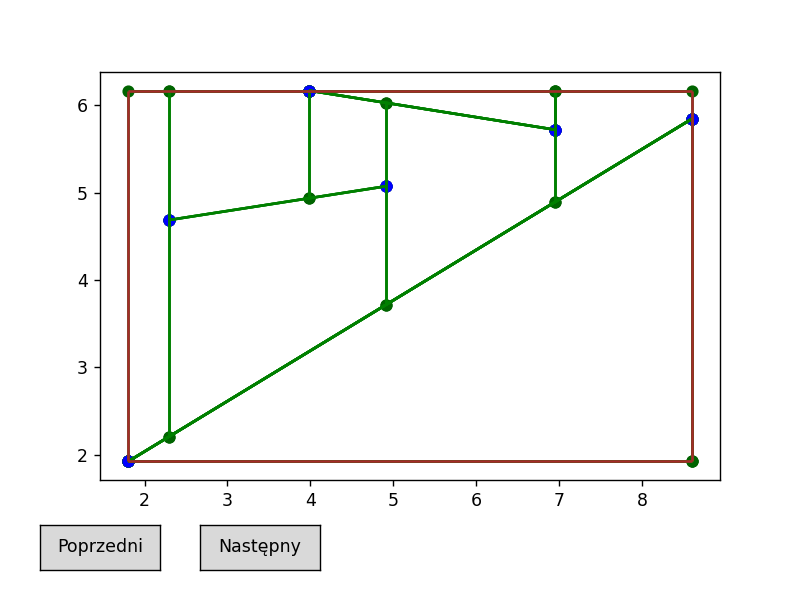

In [8]:
%matplotlib notebook
T1, scenes1 = trapezoidal_map_vis(exampleLines1)
pr1 = Presenter(scenes1)
pr1.display()

<IPython.core.display.Javascript object>


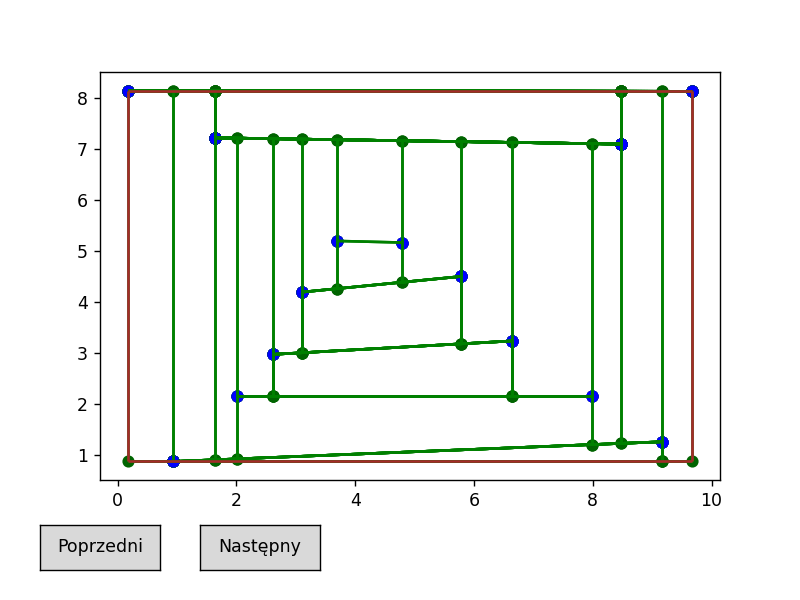

In [9]:
T2, scenes2 = trapezoidal_map_vis(exampleLines2)
pr2 = Presenter(scenes2)
pr2.display()

<IPython.core.display.Javascript object>


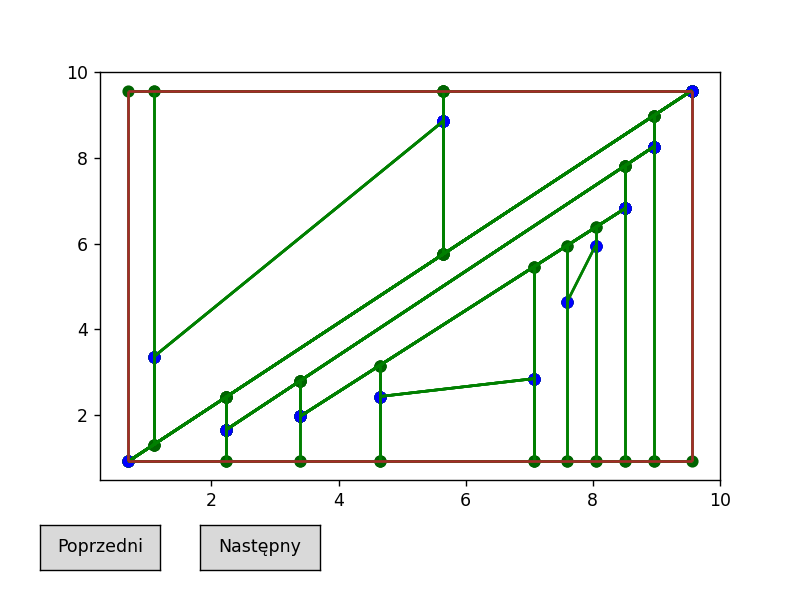

In [10]:
T3, scenes3 = trapezoidal_map_vis(exampleLines3)
pr3 = Presenter(scenes3)
pr3.display()

<IPython.core.display.Javascript object>


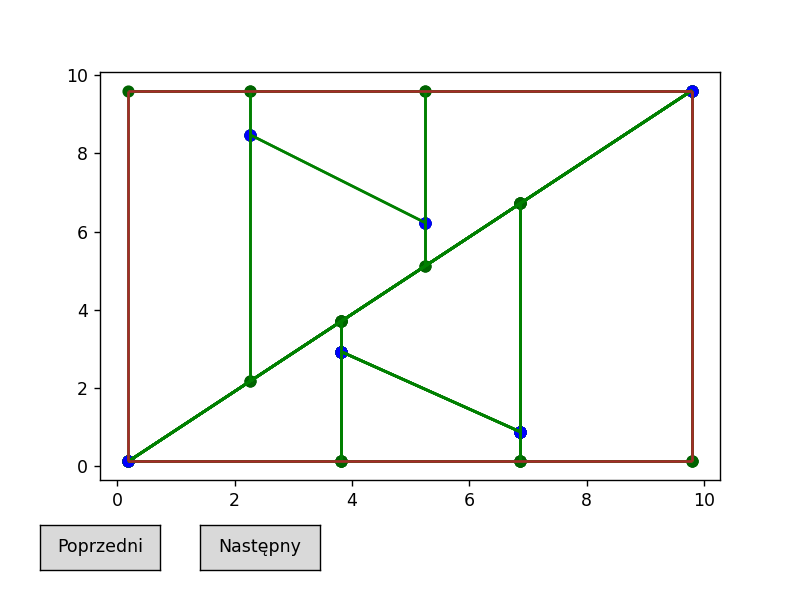

In [11]:
T4, scenes4 = trapezoidal_map_vis(exampleLines4)
pr4 = Presenter(scenes4)
pr4.display()

<IPython.core.display.Javascript object>


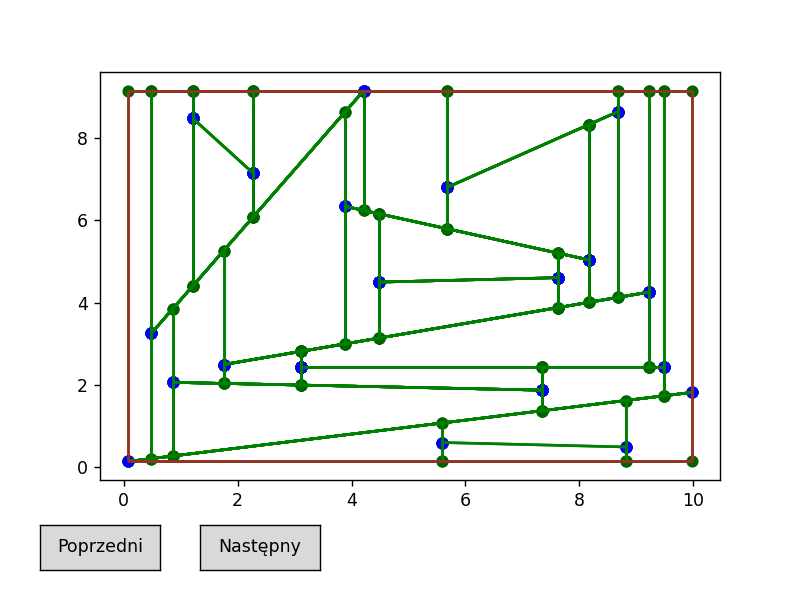

In [12]:
T5, scenes5 = trapezoidal_map_vis(exampleLines5)
pr5 = Presenter(scenes5)
pr5.display()

### Przetestuj własny zbiór odcinków! 
Punkt dodaje się poprzez kliknięcie lewym przyciskiem myszy, dwa kolejne punkty utworzą odcinek.

<IPython.core.display.Javascript object>


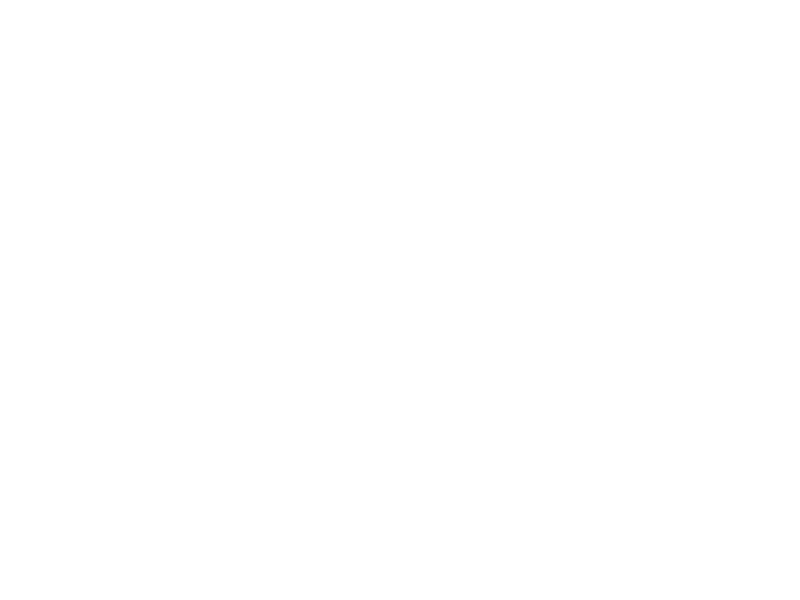

<IPython.core.display.Javascript object>


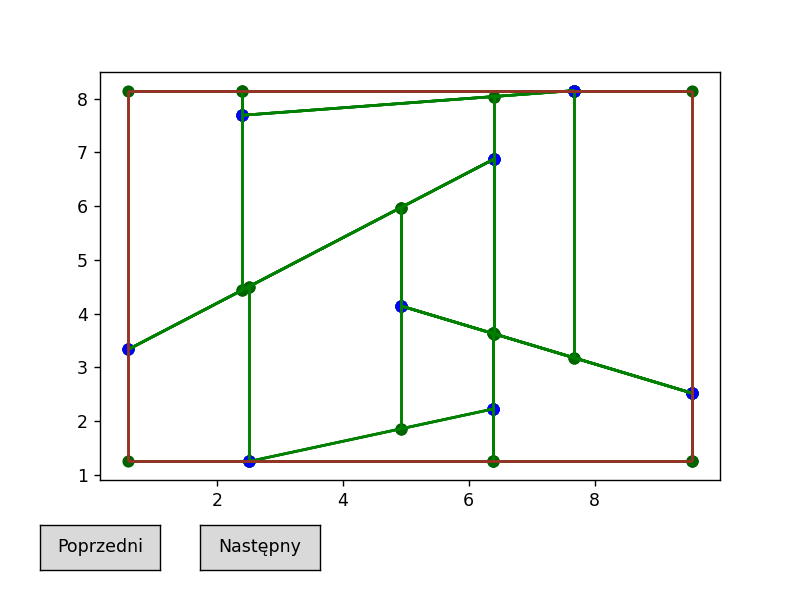

In [13]:
%matplotlib notebook
root = tk.Tk()
pt = Plotter(root)
tk.mainloop() 

<IPython.core.display.Javascript object>


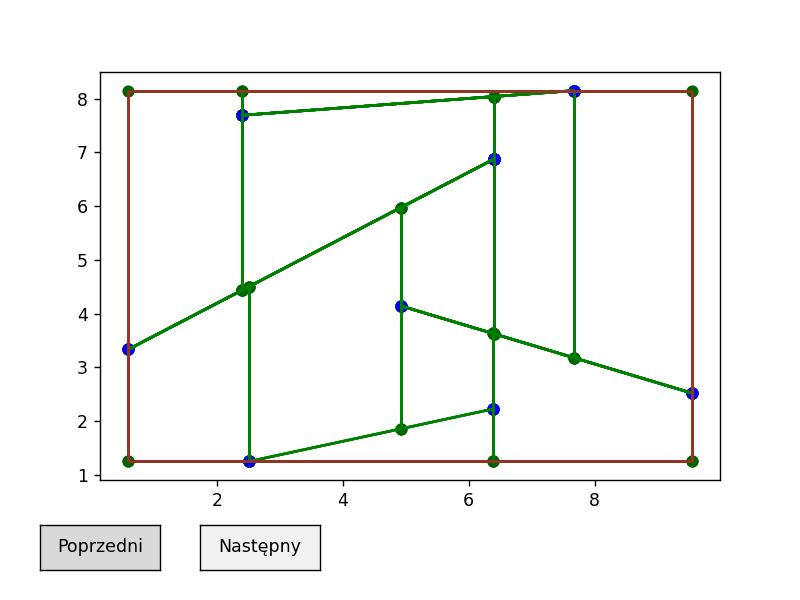

In [14]:
T, scenes = trapezoidal_map_vis(pt.lineSegments)
pr = Presenter(scenes)
pr.display()

## Wizualizacja szukania najmniejszego trapezu zawierającego zadany punkt

<IPython.core.display.Javascript object>


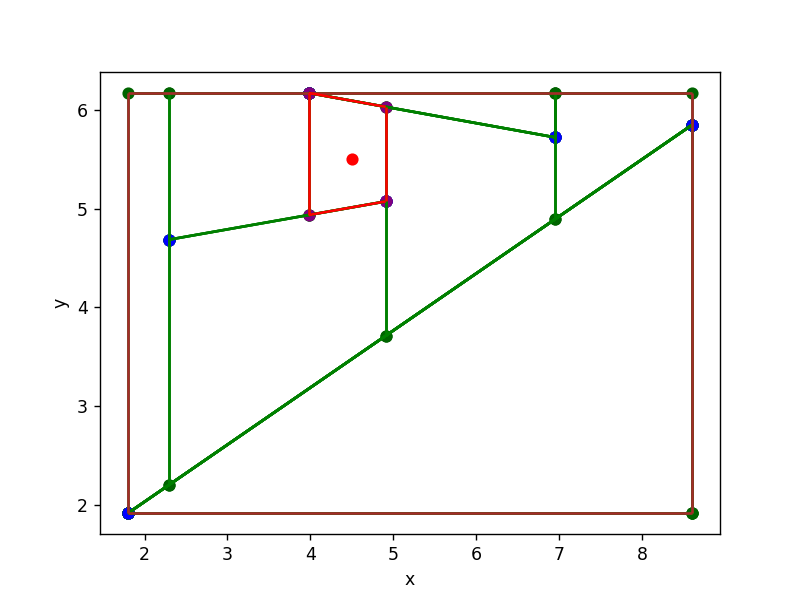

In [15]:
P = Point(4.5,5.5)
findPointVisualised(exampleLines1, P)

<IPython.core.display.Javascript object>


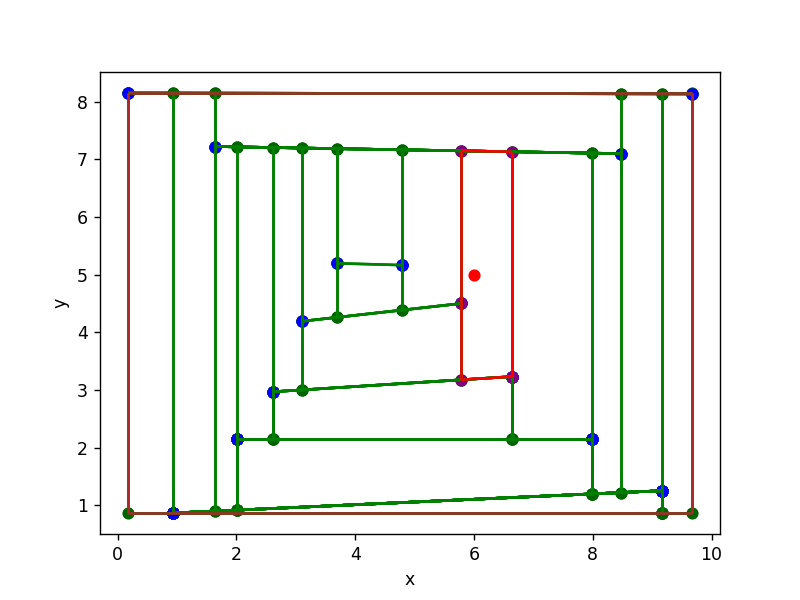

In [16]:
P = Point(6,5)
findPointVisualised(exampleLines2, P)

<IPython.core.display.Javascript object>


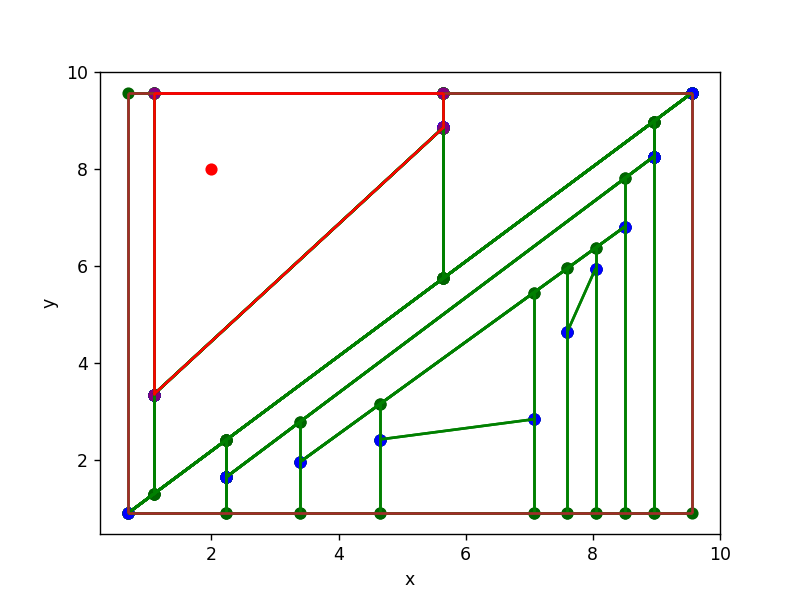

In [17]:
P = Point(2,8)
findPointVisualised(exampleLines3, P)

<IPython.core.display.Javascript object>


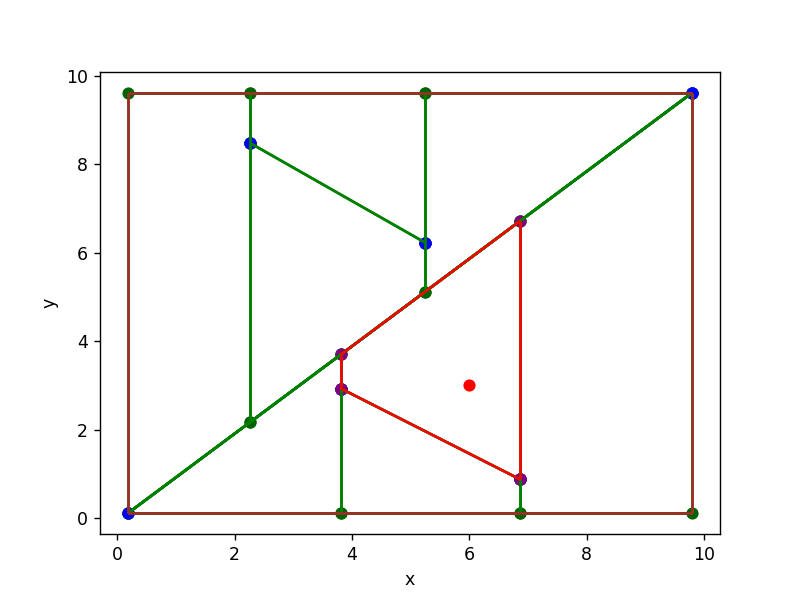

In [18]:
P = Point(6,3)
findPointVisualised(exampleLines4, P)

<IPython.core.display.Javascript object>


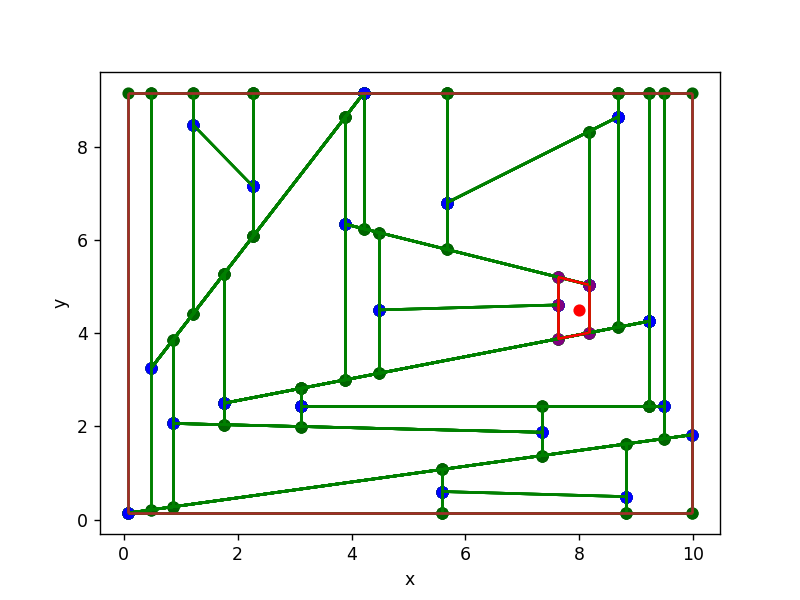

In [19]:
P = Point(8,4.5)
findPointVisualised(exampleLines5, P)